In [1]:
import os
import netCDF4 as nc4
import numpy as np
import matplotlib.pyplot as plt
from pysgrid.sgrid import SGrid

In [2]:
SGRID_URL = 'http://geoport.whoi.edu/thredds/dodsC/coawst_4/use/fmrc/coawst_4_use_best.ncd'
TIME_SLICE = -1
VERTICAL_SLICE = -1
SUB = 3
SCALE = 3

In [3]:
os.environ['TCL_LIBRARY'] = 'C:/Python279/tcl/tcl8.5'
os.environ['TK_LIBRARY'] = 'C:/Python279/tcl/tk8.5'

In [4]:
%matplotlib inline

In [5]:
def determine_avg_axis(array_shape, dim_0_max, dim_1_max):
    try:
        avg_axis = array_shape.index(dim_0_max)
    except ValueError:
        avg_axis = array_shape.index(dim_1_max)
    return avg_axis

In [6]:
def avg_to_cell_center(data_array, avg_dim):
    if avg_dim == 0:
        da = np.transpose(data_array)
    else:
        da = data_array
    da_trim_low = da[:, 1:]
    da_trim_high = da[:, :-1]
    da_avg_raw = 0.5 * (da_trim_low + da_trim_high)
    if avg_dim == 0:
        da_avg = np.transpose(da_avg_raw)
    else:
        da_avg = da_avg_raw
    return da_avg

In [7]:
def rotate_vectors(x_arr, y_arr, angle_arr):
    x_rot = x_arr*np.cos(angle_arr) - y_arr*np.sin(angle_arr)
    y_rot = x_arr*np.sin(angle_arr) + y_arr*np.cos(angle_arr)
    return x_rot, y_rot

In [8]:
def vector_sum(x_arr, y_arr):
    vector_sum = np.sqrt(x_arr**2 + y_arr**2)
    return vector_sum

In [14]:
def display_shape(var_array, display_text):
    array_shape = var_array.shape
    message = '{display_text} shape: {shape}'.format(display_text=display_text,
                                                     shape=array_shape
                                                     )
    print(message)

u raw shape: (334, 895)
v raw shape: (335, 894)
angle shape: (336, 896)
rho mask shape: (336, 896)
[GridPadding(mesh_topology_var=u'grid', face_dim=u'xi_rho', node_dim=u'xi_psi', padding=u'both'), GridPadding(mesh_topology_var=u'grid', face_dim=u'eta_rho', node_dim=u'eta_psi', padding=u'both')]
[GridPadding(mesh_topology_var=u'grid', face_dim=u'eta_u', node_dim=u'eta_psi', padding=u'both')]
[GridPadding(mesh_topology_var=u'grid', face_dim=u'xi_v', node_dim=u'xi_psi', padding=u'both')]
[GridPadding(mesh_topology_var=u'grid', face_dim=u's_rho', node_dim=u's_w', padding=u'none')]
u trim shape: (334, 895)
v trim shape: (335, 894)
angle trim shape: (334, 894)
rho mask trim shape: (334, 894)
u avg dim: 1
v avg dim: 0
u avg shape: (334, 894)
v avg shape: (334, 894)
uv vector sum shape: (334, 894)


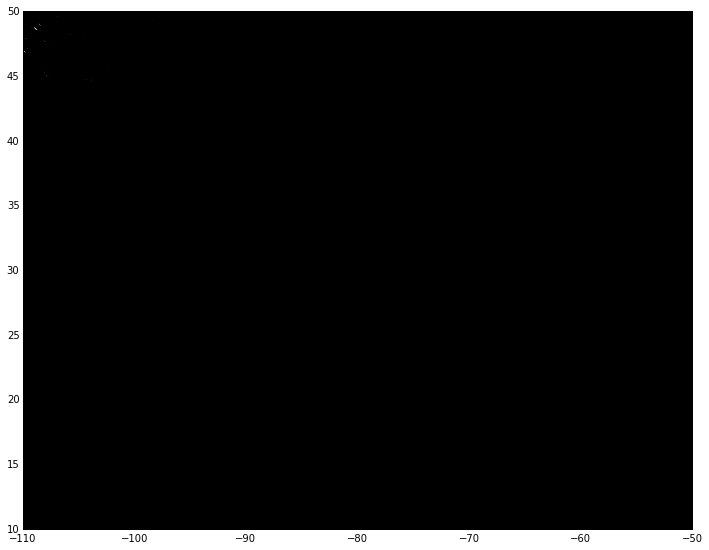

In [15]:
coawst = nc4.Dataset(SGRID_URL)
sgc = SGrid().from_nc_dataset(coawst)
grid_center_lon = sgc.grid_cell_center_lon
# print(grid_center_lon)
grid_center_lat = sgc.grid_cell_center_lat
u_slice = sgc.u_slice[2:]
u_slice = np.s_[TIME_SLICE, VERTICAL_SLICE] + u_slice
u_raw = coawst.variables['u'][u_slice]
display_shape(u_raw, 'u raw')
v_slice = sgc.v_slice[2:]
v_slice = np.s_[TIME_SLICE, VERTICAL_SLICE] + v_slice
v_raw = coawst.variables['v'][v_slice]
display_shape(v_raw, 'v raw')
angle = coawst.variables['angle'][:]
display_shape(angle, 'angle')
rho_mask = coawst.variables['mask_rho'][:]
display_shape(rho_mask, 'rho mask')
# print(rho_mask)
face_padding = sgc.face_padding
print(face_padding)
print(sgc.edge_1_padding)
print(sgc.edge_2_padding)
print(sgc.vertical_padding)
u_trim = u_raw
v_trim = v_raw
display_shape(u_trim, 'u trim')
display_shape(v_trim, 'v trim')
#angle_trim = angle[1:-1, 1:-1]  # rows and columns
angle_trim = angle[sgc.angle_slice]
rho_mask_trim = rho_mask[sgc.mask_rho_slice]
display_shape(angle_trim, 'angle trim')
display_shape(rho_mask_trim, 'rho mask trim')
u_trim_shape = u_trim.shape
v_trim_shape = v_trim.shape
uv_dim_0 = (u_trim_shape[0], v_trim_shape[0])
uv_dim_1 = (u_trim_shape[1], v_trim_shape[1])
dim_0_max = max(uv_dim_0)
dim_1_max = max(uv_dim_1)
u_avg_dim = determine_avg_axis(u_trim_shape, dim_0_max, dim_1_max)
v_avg_dim = determine_avg_axis(v_trim_shape, dim_0_max, dim_1_max)
print('u avg dim: {0}'.format(u_avg_dim))
print('v avg dim: {0}'.format(v_avg_dim))
u_avg = avg_to_cell_center(u_trim, u_avg_dim)  # y
v_avg = avg_to_cell_center(v_trim, v_avg_dim)  # x
display_shape(u_avg, 'u avg')
display_shape(v_avg, 'v avg')
v_rot, u_rot = rotate_vectors(v_avg, u_avg, angle_trim)
lon_rho = coawst.variables['lon_rho'][sgc.lon_rho_slice]
lat_rho = coawst.variables['lat_rho'][sgc.lat_rho_slice]
uv_sum = vector_sum(v_rot, u_rot)
# print(uv_sum)
display_shape(uv_sum, 'uv vector sum')
fig = plt.figure(figsize=(12, 12))
plt.subplot(111, aspect=(1.0/np.cos(np.mean(lat_rho)*np.pi/180.0)))
plt.pcolormesh(lon_rho, lat_rho, uv_sum)
q = plt.quiver(lon_rho[::SUB, ::SUB], lat_rho[::SUB, ::SUB], v_rot[::SUB, ::SUB], u_rot[::SUB, ::SUB], 
               scale=1.0/SCALE, pivot='middle', zorder=1e35, width=0.003)
plt.quiverkey(q, 0.85, 0.07, 1.0, label=r'1 m s$^{-1}$', coordinates='figure')
plt.show()